In [1]:
library(igraph)
library(tidyverse)
library(tidygraph)
library(ggnetwork)
suppressWarnings(suppressMessages(library(network)))
suppressWarnings(suppressMessages(library(sna)))

results <- '../results/'
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
    select(Gene, `Top-0.1-pvalue`)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()

Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups



# Subnetworks

## LEAN

In [2]:
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd')
g_lean <- activate(ppi, nodes) %>%
    filter(name %in% lean$Gene[lean$PLEAN < 0.05])

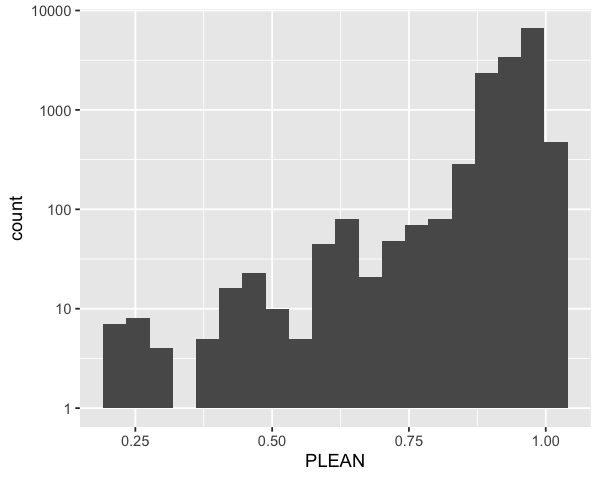

In [3]:
options(repr.plot.width=5, repr.plot.height=4)
ggplot(lean, aes(PLEAN)) +
    geom_histogram(bins = 20) +
    scale_y_log10()

## Sigmod

In [4]:
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')
g_sigmod <- activate(ppi, nodes) %>%
    filter(name %in% sigmod$gene) %>%
    mutate(sigmod = TRUE)
class(g_sigmod) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”

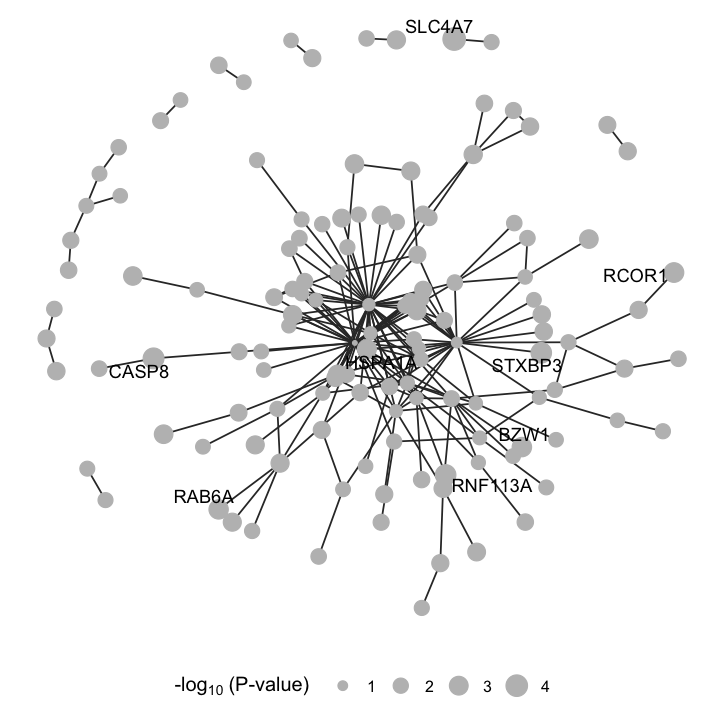

In [5]:
options(repr.plot.width=6, repr.plot.height=6)
g_sigmod %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(`Top-0.1-pvalue`)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(`Top-0.1-pvalue` < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## dmGWAS

In [6]:
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')

In [7]:
g_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas$gene) %>%
    mutate(dmgwas = TRUE)
class(g_dmgwas) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”

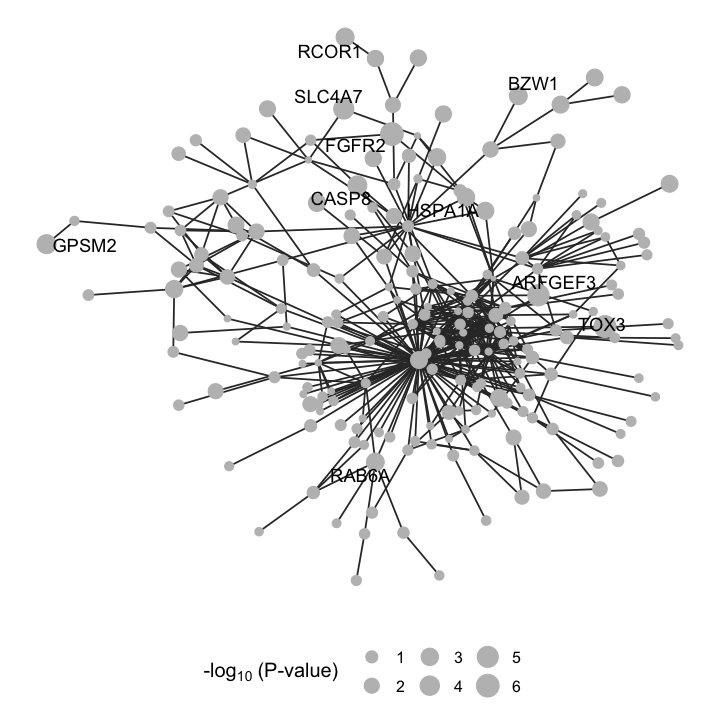

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
g_dmgwas %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(`Top-0.1-pvalue`)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(`Top-0.1-pvalue` < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## Hierarchical HotNet

In [9]:
hotnet <- read_tsv(paste0(results,'hierarchical_hotnet/selected_genes.hotnet.txt'), comment = '#', col_names = F)
hotnet <- head(hotnet, nrow(hotnet) * 0.001) %>%
    gather(colname, gene) %>%
    filter(!is.na(gene)) %>%
    select(-colname)

Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message:
“15243 parsing failures.
row col   expected     actual                                                       file
  2  -- 44 columns 12 columns '../results/hierarchical_hotnet/selected_genes.hotnet.txt'
  3  -- 44 columns 11 columns '../results/hierarchical_hotnet/selected_genes.hotnet.txt'
  4  -- 44 columns 11 columns '../results/hierarchical_hotnet/selected_genes.hotnet.txt'
  5  -- 44 columns 10 columns '../results/hierarchical_hotnet/selected_genes.hotnet.txt'
  6  -- 44 columns 9 columns  '../results/hierarchical_hotnet/selected_genes.hotnet.txt'
... ... .......... .......... ..........................................................
See problems(...) for more details.
”

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”

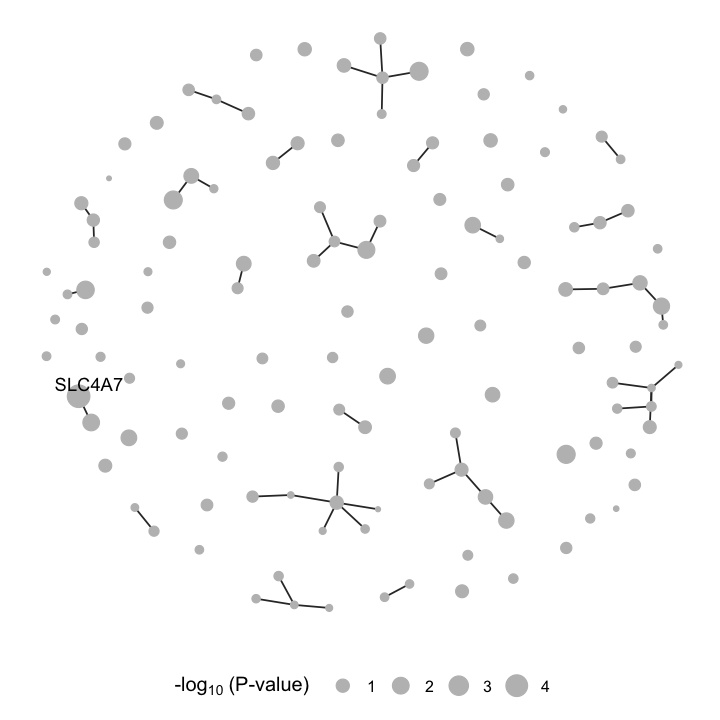

In [10]:
g_hotnet <- activate(ppi, nodes) %>%
    filter(name %in% hotnet$gene) %>%
    mutate(hotnet = TRUE)
class(g_hotnet) <- c('igraph','tbl_graph')

options(repr.plot.width=6, repr.plot.height=6)
g_hotnet %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(`Top-0.1-pvalue`)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(`Top-0.1-pvalue` < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## Heinz

In [11]:
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')

In [12]:
g_heinz <- activate(ppi, nodes) %>%
    filter(name %in% heinz$gene) %>%
    mutate(heinz = TRUE)
class(g_heinz) <- c('igraph','tbl_graph')

## SConES GM

In [13]:
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    unique
scones

g_scones <- activate(ppi, nodes) %>%
    filter(name %in% scones$gene) %>%
    mutate(scones = TRUE)
class(g_scones) <- c('igraph','tbl_graph')

gene
<chr>
NEK10
MICOS10P3
RNU6-342P
SLC4A7
RPS20P15
RNU1-96P
FGF10
FGF10-AS1
LINC02224


# Consensus subnetwork

In [14]:
# from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4478970/
known_brca_genes <- c('BRCA1','BRCA2','CDH1','PTEN','STK11','TP53,ATM','BRIP1','CHEK2','PALB2','AKT1','APC','ATR','BABAM1','BAP1','BARD1','BMPR1A','CDK4','CDKN2A','CHEK1','CTNNA1','EPCAM','FAM175A','MLH1','MRE11A','MSH2','MSH6','MUTYH','NBN','PIK3CA','PMS2','POLD1','POLE','PRSS1','RAD50','RAD51','RAD51C','RAD51D','RET','SDHB','SDHC','SDHD','SMAD4','TP53BP1','VHL','XRCC2','TP53','GALNT12','GREM1','NF1','BLM','FANCC','HOXB13','AXIN2','PALLD','PMS1','ALK','CDC73','CDKN1C','FH','FLCN','GPC3','MAX','MEN1','MET','NF2','PHOX2B','PRKAR1A','PTCH1','SDHAF2','SUFU','TMEM127','WT1','ERCC4','FANCA','FANCD2','FANCE','FANCF','FANCG','MSH3','SLX4','UIMC1')
g_known <- activate(ppi, nodes) %>%
    filter(name %in% known_brca_genes) %>%
    mutate(known = TRUE)
class(g_known) <- c('igraph','tbl_graph')

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”Warning message:
“Ignoring unknown aesthetics: xend, yend”Warning message:
“Ignoring unknown aesthetics: xend, yend”

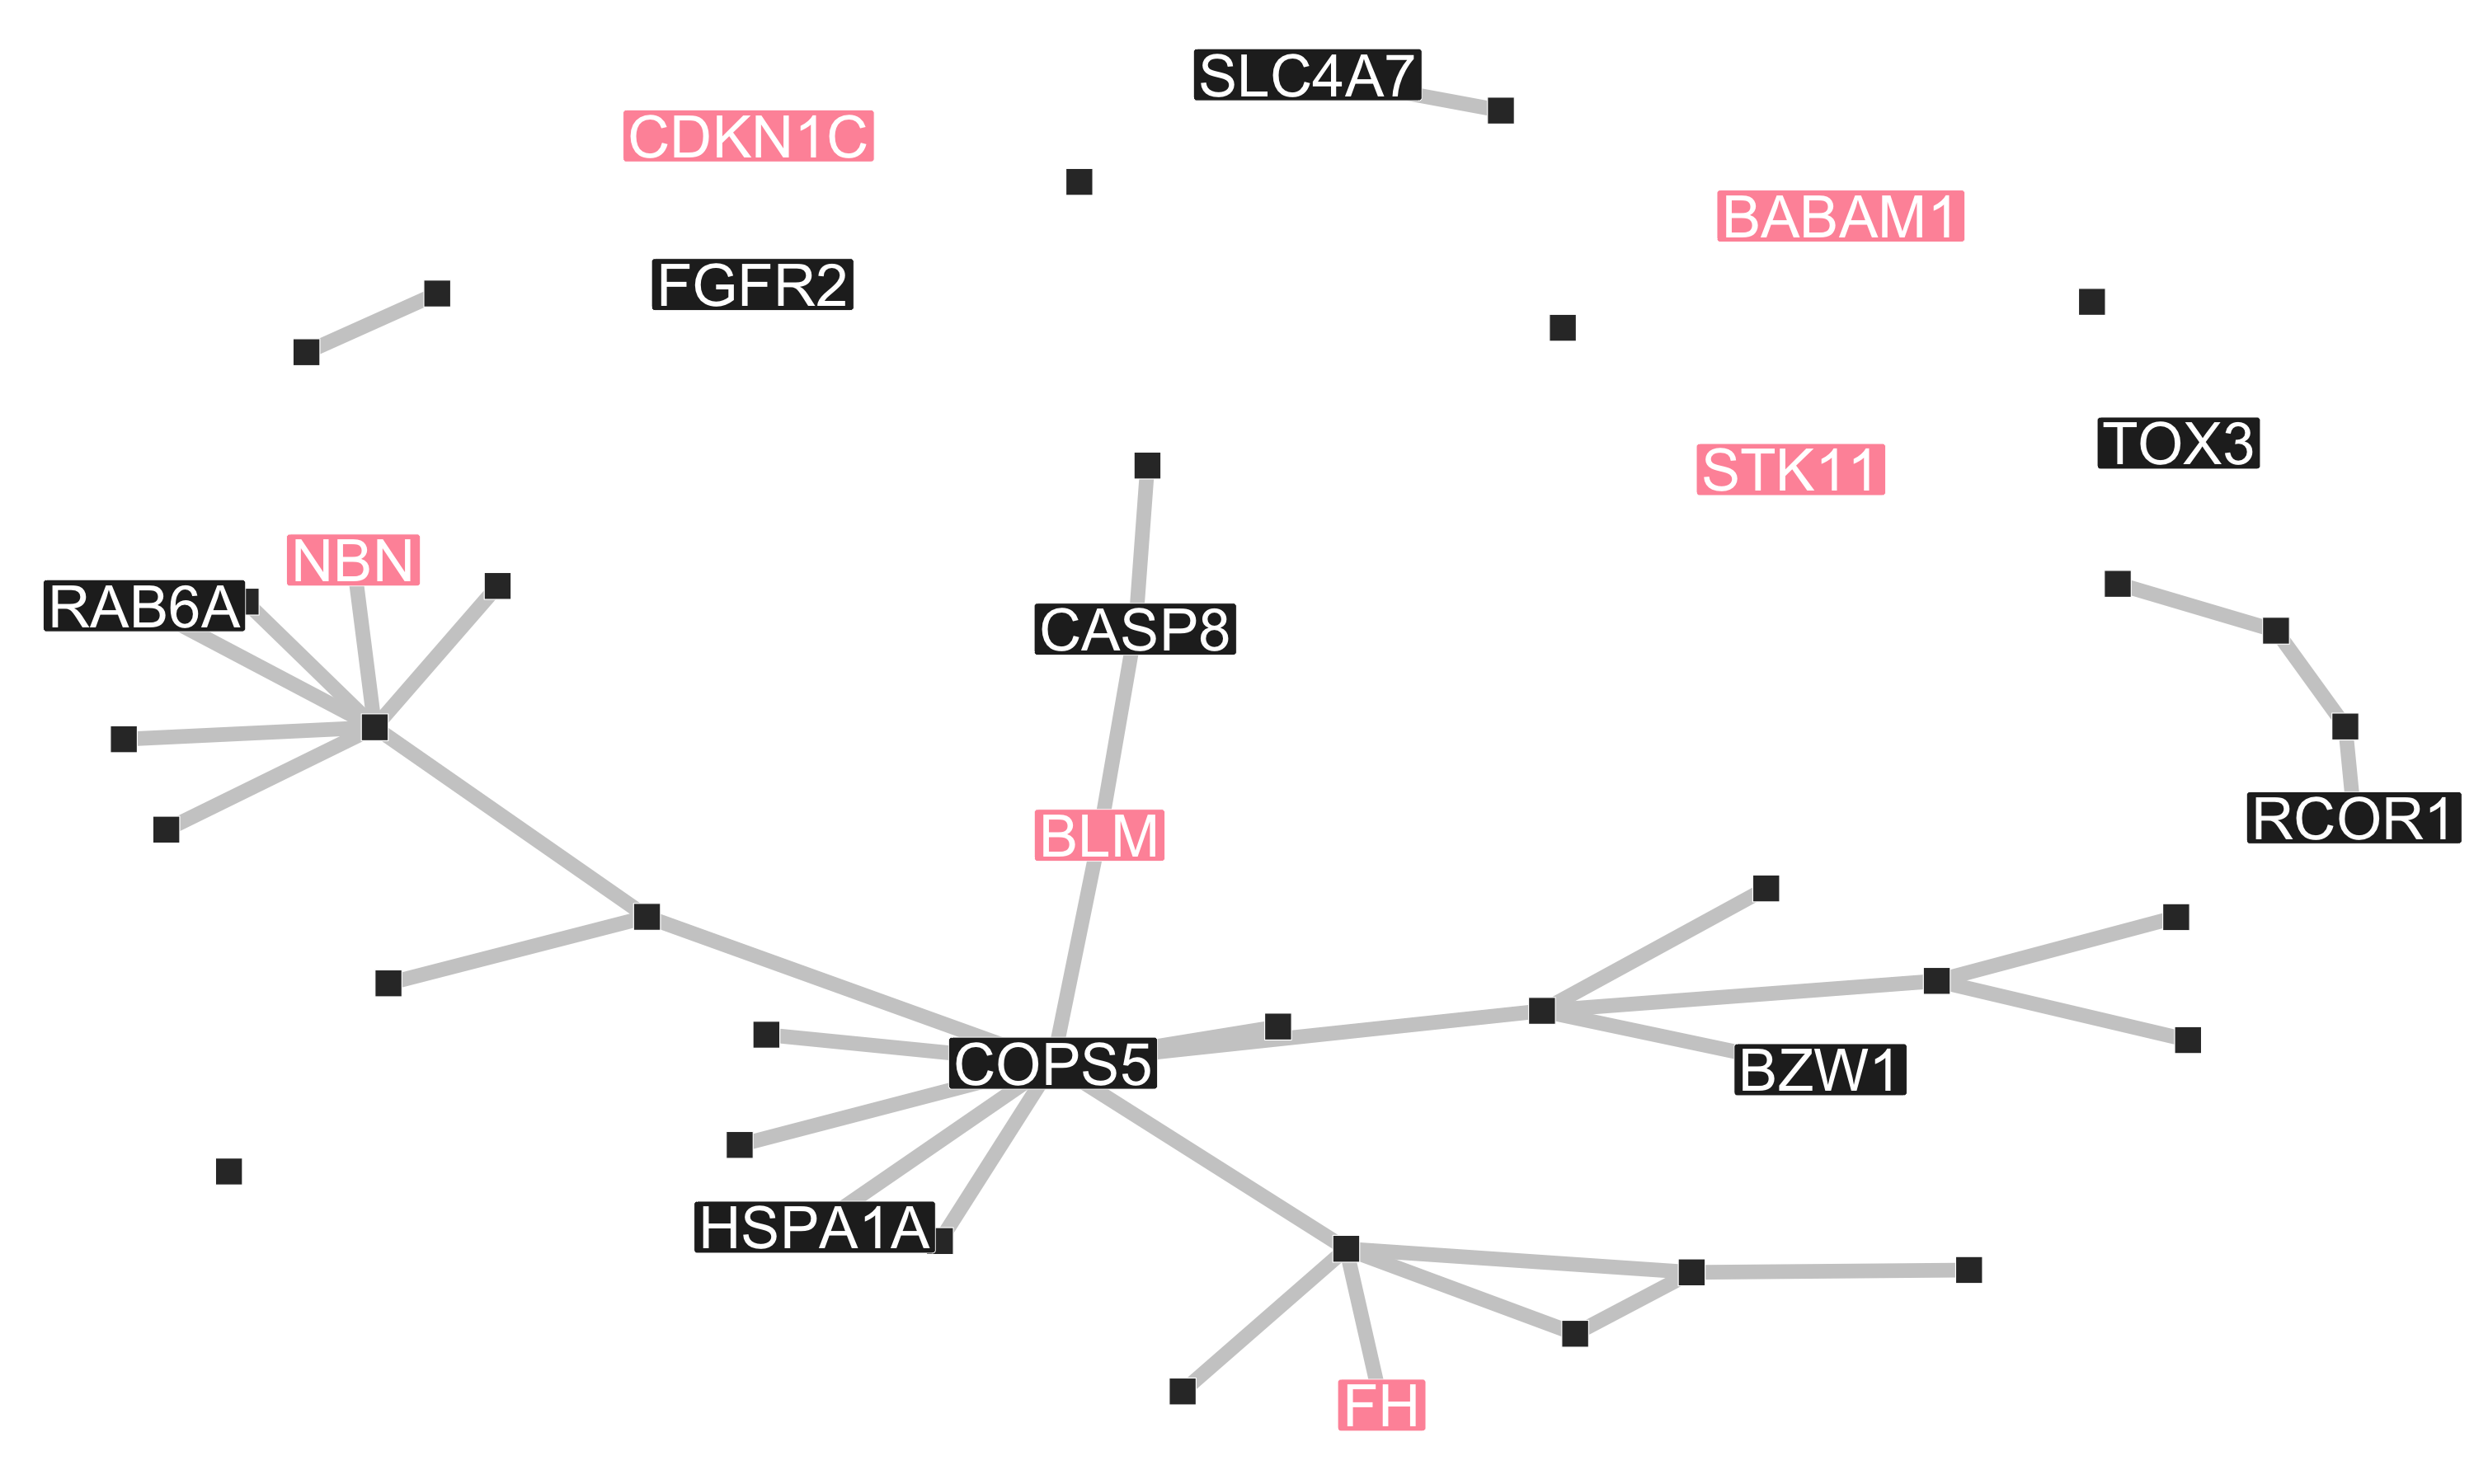

In [15]:
options(repr.plot.width=25, repr.plot.height=15)
consensus <- graph_join(g_sigmod, g_dmgwas, by = "name") %>%
    graph_join(g_hotnet, by = "name") %>%
    graph_join(g_heinz, by = "name") %>%
    graph_join(g_scones, by = "name") %>%
    graph_join(g_known, by = "name") %>%
    to_undirected %>%
    mutate(num_methods = rowSums(cbind(dmgwas, sigmod, hotnet, heinz, scones, known), na.rm = TRUE),
           known = ifelse(is.na(known), FALSE, known)) %>%
    filter(num_methods > 1) %>%
    mutate(degree = centrality_degree()) 

as.tibble(consensus) %>%
    write_tsv(paste0(results,'consensus/consensus.tsv'))

consensus <- consensus %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names))

highlight <- consensus$num_methods == 3 | consensus$`Top-0.1-pvalue` < 0.001 | consensus$degree > 20 | consensus$known

ggplot() +
    geom_edges(data = consensus, aes(x = x, y = y, xend = xend, yend = yend), size = 5, color = 'grey80') +
    geom_nodes(data = filter(consensus, !highlight), 
               aes(x = x, y = y, xend = xend, yend = yend), size = 10, fill = 'gray20', color = 'white', shape = 22) +
    geom_nodelabel(data = filter(consensus, highlight), 
                   aes(x = x, y = y, xend = xend, yend = yend, label = vertex.names, fill = known), size = 15, color = 'white') +
    theme_blank() +
    labs(size = '# methods') +
    scale_size_manual(values = c('2' = 6, '3' = 10)) +
    scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
    theme(text = element_text(size = 40), legend.position = 'none')

# Gene set enrichment analysis

In [16]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))

In [17]:
enrichGO(gene    = unique(consensus[['vertex.names']]),
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as_tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044183,protein binding involved in protein folding,3/47,23/17632,3.028265e-05,0.002619449,0.002024156,HSPA1A/HSPA1B/HSPA1L,3
GO:0051787,misfolded protein binding,3/47,23/17632,3.028265e-05,0.002619449,0.002024156,HSPA1A/HSPA1B/HSPA1L,3
GO:0051082,unfolded protein binding,4/47,127/17632,3.602829e-04,0.020776313,0.016054711,HSPA1A/HSPA1B/HSPA1L/CCT7,4
GO:0016887,ATPase activity,6/47,445/17632,1.116940e-03,0.048307669,0.037329321,HSPA1A/HSPA1B/HSPA1L/BLM/ABCF1/NBN,6
